In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ======================================================
# 1. Generate Lagged Sine Wave Data
# ======================================================
seq_len = 50
tau = 5
batch_size = 64
n_batches = 2000

def generate_batch(batch_size, seq_len, tau):
    t = torch.arange(seq_len).float().unsqueeze(0).repeat(batch_size, 1)
    x = torch.sin(t / 5.0)
    y = torch.sin((t - tau) / 5.0) + 0.05 * torch.randn_like(x)
    return x.unsqueeze(-1), y.unsqueeze(-1)  # (B, T, 1)

# 1) White noise (non-integrated): sharpest possible alignment
def generate_batch_wn(batch_size, seq_len, tau, obs_noise=0.01):
    x = torch.randn(batch_size, seq_len)
    y = torch.roll(x, shifts=tau, dims=1)
    y[:, :tau] = 0.0                     # prevent wraparound leakage
    y = y + obs_noise * torch.randn_like(y)
    return x.unsqueeze(-1), y.unsqueeze(-1)

# ======================================================
# 2. Build Tiny Transformer (Encoder–Decoder)
# ======================================================
d_model = 32
nhead = 1
num_layers = 1

encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

in_proj = nn.Linear(1, d_model)
out_proj = nn.Linear(d_model, 1)

# ======================================================
# 3. Training Loop
# ======================================================
optimizer = optim.Adam(
    list(encoder.parameters()) +
    list(decoder.parameters()) +
    list(in_proj.parameters()) +
    list(out_proj.parameters()),
    lr=5e-4
)

loss_fn = nn.MSELoss()

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


In [ ]:
loss_history = []  # <--- Add this before training

In [ ]:
print("Training...")
for step in range(n_batches):
    x, y = generate_batch_wn(batch_size, seq_len, tau)
    x_emb = in_proj(x)
    y_emb = in_proj(y)

    mem = encoder(x_emb)
    out = decoder(y_emb, mem)
    y_pred = out_proj(out)

    loss = loss_fn(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record loss for plotting
    loss_history.append(loss.item())

    if (step + 1) % 100 == 0:
        print(f"Step {step+1}/{n_batches}, Loss: {loss.item():.6f}")

Training...
Step 100/2000, Loss: 0.000195
Step 200/2000, Loss: 0.000219
Step 300/2000, Loss: 0.000205
Step 400/2000, Loss: 0.000261
Step 500/2000, Loss: 0.000208
Step 600/2000, Loss: 0.000215
Step 700/2000, Loss: 0.000180
Step 800/2000, Loss: 0.000194
Step 900/2000, Loss: 0.000235
Step 1000/2000, Loss: 0.000254
Step 1100/2000, Loss: 0.000212
Step 1200/2000, Loss: 0.000234
Step 1300/2000, Loss: 0.000178
Step 1400/2000, Loss: 0.000187
Step 1500/2000, Loss: 0.000166
Step 1600/2000, Loss: 0.000177
Step 1700/2000, Loss: 0.000177
Step 1800/2000, Loss: 0.000126
Step 1900/2000, Loss: 0.000128
Step 2000/2000, Loss: 0.000114


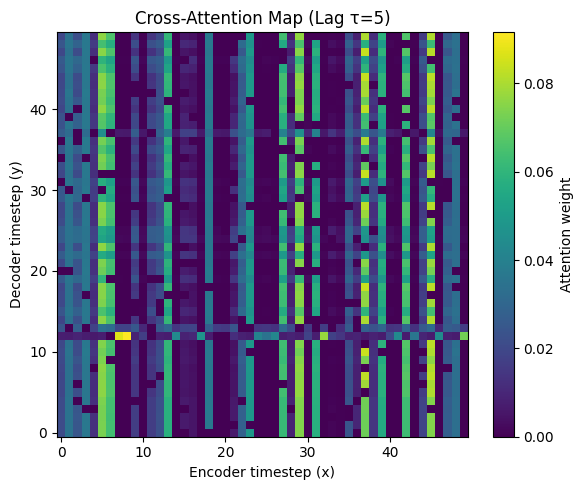

In [ ]:
# assume: encoder, decoder, in_proj, out_proj already trained; batch_first=True
# single example
x, y = generate_batch_wn(1, seq_len, tau)
x_emb = in_proj(x)
y_emb = in_proj(y)
mem = encoder(x_emb)

# ---- use the FIRST decoder layer exactly as it does internally ----
layer = decoder.layers[0]

# 1) self-attention on the decoder inputs (teacher forcing)
tgt = y_emb
tgt2 = layer.self_attn(tgt, tgt, tgt, need_weights=False)[0]
tgt = layer.norm1(tgt + layer.dropout1(tgt2))

# 2) cross-attention (this is what we want to visualize)
tgt2, attn = layer.multihead_attn(
    tgt,           # real queries (not zeros)
    mem, mem,
    need_weights=True,
    average_attn_weights=True   # -> (B, T_dec, T_enc)
)
tgt = layer.norm2(tgt + layer.dropout2(tgt2))

attn_map = attn[0].detach().cpu().numpy()   # shape (T_dec, T_enc)
plt.figure(figsize=(6,5))
plt.imshow(attn_map, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Attention weight')
plt.xlabel('Encoder timestep (x)')
plt.ylabel('Decoder timestep (y)')
plt.title(f'Cross-Attention Map (Lag τ={tau})')
plt.tight_layout(); plt.show()


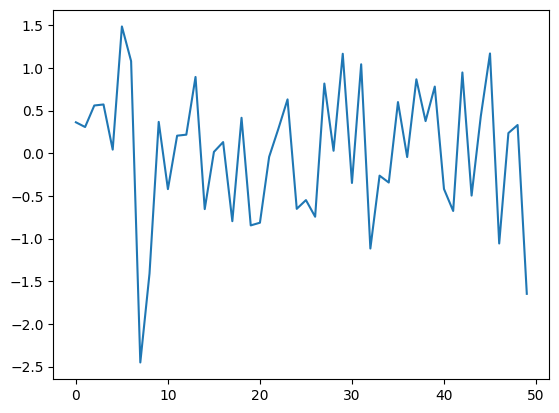

In [ ]:
plt.plot(x.detach().cpu().numpy()[0])

In [ ]:
plt.plot(loss_history)
plt.xlabel("Step")
plt.ylabel("MSE Loss")
plt.yscale("log")

NameError: name 'loss_history' is not defined